# Predictive Analysis: Default of Credit Card Clients


In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import gc
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline 

from datetime import datetime 
from pandas import to_datetime
from sklearn import metrics, tree
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from numpy.random.mtrand import _rand as global_randstate

from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, RandomizedSearchCV 
from sklearn.metrics import precision_score, recall_score, roc_auc_score,roc_curve,auc, plot_confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, plot_precision_recall_curve, classification_report

In [2]:
#importing the dataset
data_df = pd.read_excel(r'/Users/matthewkondrak/Desktop/default.xls', header = 0)
new_header = data_df.iloc[0]
df1 = data_df[1:]
df1.columns = new_header
df1

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29999,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


Data Description

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 1 to 30000
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  object
 1   LIMIT_BAL                   30000 non-null  object
 2   SEX                         30000 non-null  object
 3   EDUCATION                   30000 non-null  object
 4   MARRIAGE                    30000 non-null  object
 5   AGE                         30000 non-null  object
 6   PAY_0                       30000 non-null  object
 7   PAY_2                       30000 non-null  object
 8   PAY_3                       30000 non-null  object
 9   PAY_4                       30000 non-null  object
 10  PAY_5                       30000 non-null  object
 11  PAY_6                       30000 non-null  object
 12  BILL_AMT1                   30000 non-null  object
 13  BILL_AMT2                   30000 non-null  ob

In [4]:
#Updating the Data Type to float64 for dollars amount features for later training models and int64 for the rest of the data
df1 = df1.astype({'ID':'int64',
                 'LIMIT_BAL':'float64',
                 'SEX':'int64',
                 'EDUCATION':'int64',
                 'MARRIAGE':'int64',
                 'AGE':'int64',
                 'PAY_0':'int64',
                 'PAY_2':'int64',
                 'PAY_3':'int64',
                 'PAY_4':'int64',
                 'PAY_5':'int64',
                 'PAY_6':'int64',
                 'BILL_AMT1':'float64',
                 'BILL_AMT2':'float64',
                 'BILL_AMT3':'float64',
                 'BILL_AMT4':'float64',
                 'BILL_AMT5':'float64',
                 'BILL_AMT6':'float64',
                 'PAY_AMT1':'float64',
                 'PAY_AMT2':'float64',
                 'PAY_AMT3':'float64',
                 'PAY_AMT4':'float64',
                 'PAY_AMT5':'float64',
                 'PAY_AMT6':'float64',
                 'default payment next month':'int64'
                 })

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 1 to 30000
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [5]:
df1.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [6]:
#checking if there's any missing data
total = df1.isnull().sum().sort_values(ascending = False)
percent = (df1.isnull().sum() / df1.isnull().count() * 100).sort_values(ascending = False)
pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent']).transpose()

,ID,BILL_AMT2,PAY_AMT6,PAY_AMT5,PAY_AMT4,PAY_AMT3,PAY_AMT2,PAY_AMT1,BILL_AMT6,BILL_AMT5,...,PAY_5,PAY_4,PAY_3,PAY_2,PAY_0,AGE,MARRIAGE,EDUCATION,SEX,default payment next month
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#renaming columns for easier understanding
df1 = df1.rename(columns = {'PAY_0': 'PAY_1', 'default payment next month': 'default_payment_result'})
df1 = df1.drop(columns = 'ID')

Plot of Default Credit Card Clients in Dataset

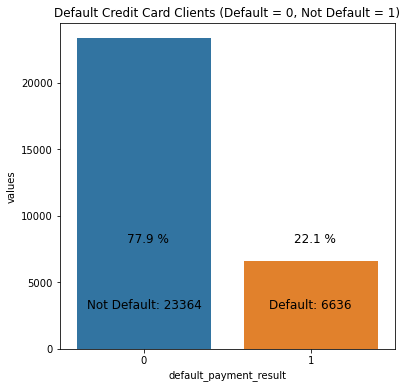

In [8]:
#EDA
yes = df1.default_payment_result.sum()
no = len(df1) - yes

# Percentage
yes_perc = round(yes / len(df1) * 100, 1)
no_perc = round(no / len(df1) * 100, 1)

temp = df1["default_payment_result"].value_counts()
df = pd.DataFrame({'default_payment_result': temp.index, 'values': temp.values})

#plot figure
plt.figure(figsize = (6, 6))
plt.title('Default Credit Card Clients (Default = 0, Not Default = 1)')
plt.annotate('Not Default: {}'.format(no), xy = (-0.34, 15000), xytext = (-0.34, 3000), size = 12)
plt.annotate('Default: {}'.format(yes), xy = (0.75, 15000), xytext = (0.75, 3000), size = 12)
plt.annotate(str(no_perc) + " %", xy = (-0.34, 15000), xytext = (-0.1, 8000), size = 12)
plt.annotate(str(yes_perc) + " %", xy = (0.75, 15000), xytext = (0.9, 8000), size = 12)
sns.set_color_codes("pastel")
sns.barplot(x = 'default_payment_result', y = "values", data = df)
locs, labels = plt.xticks()
plt.show()

In [9]:
#some statistical analysis for better understanding of the dataset
df1[['BILL_AMT' + str(n) for n in range(1, 7)]] += 1
df1[['BILL_AMT' + str(n) for n in range(1, 7)]].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51224.330900,49180.075167,4.701415e+04,43263.948967,40312.400967,38872.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165579.000000,-69776.000000,-1.572630e+05,-169999.000000,-81333.000000,-339602.000000
25%,3559.750000,2985.750000,2.667250e+03,2327.750000,1764.000000,1257.000000
50%,22382.500000,21201.000000,2.008950e+04,19053.000000,18105.500000,17072.000000
75%,67092.000000,64007.250000,6.016575e+04,54507.000000,50191.500000,49199.250000
max,964512.000000,983932.000000,1.664090e+06,891587.000000,927172.000000,961665.000000


Univariate Analysis of Variables

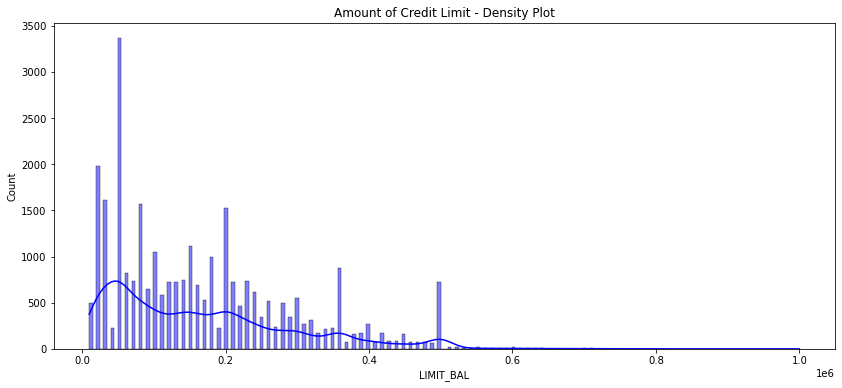

In [10]:
#Credit limit density plot
plt.figure(figsize = (14, 6))
plt.title('Amount of Credit Limit - Density Plot')
sns.set_color_codes("pastel")
sns.histplot(df1['LIMIT_BAL'], kde = True, bins = 200, color = "blue")
plt.show()

<AxesSubplot:>

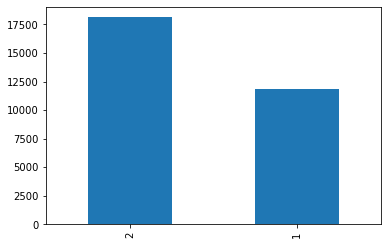

In [11]:
#showcasing the amount of female and male counts in the dataset
df1.SEX.value_counts().plot(kind = 'bar')

<AxesSubplot:>

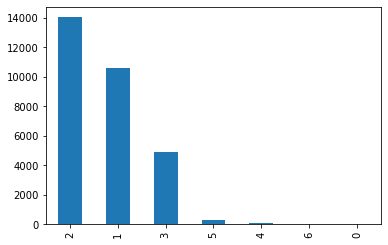

In [12]:
#showcasing the Education data of the dataset (1 = graduate school; 2 = university; 3 = high school; 4 = others))
df1.EDUCATION.value_counts().plot(kind = 'bar')

In [13]:
#Data cleaning for Marriage and Education 
#EDUCATION data cleaning (1 = graduate school; 2 = university; 3 = high school; 4 = others)
df1.loc [:,'EDUCATION'][df1['EDUCATION'] == 0] = 4
df1.loc [:,'EDUCATION'][df1['EDUCATION'] == 5] = 4
df1.loc [:,'EDUCATION'][df1['EDUCATION'] == 6] = 4
df1.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

default_payment_result  EDUCATION
0                       1             8549
                        2            10700
                        3             3680
                        4              435
1                       1             2036
                        2             3330
                        3             1237
                        4               33
dtype: int64
EDUCATION                  1      2     3    4
default_payment_result                        
0                       8549  10700  3680  435
1                       2036   3330  1237   33


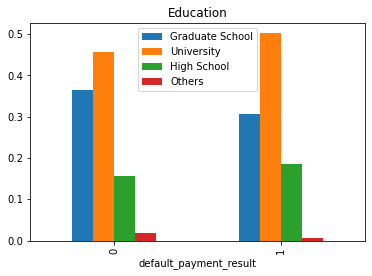

In [14]:
#grouping default payment next month by education
df1_education = df1.groupby(['default_payment_result', 'EDUCATION']).size()
print(df1_education)

df1_education = df1_education.unstack()
print(df1_education)

df1_education.loc[1] = df1_education.loc[1] / 6636
df1_education.loc[0] = df1_education.loc[0] / 23364

df1_education.plot(kind = 'bar')
plt.title('Education')
plt.legend(['Graduate School', 'University', 'High School', 'Others'])
plt.show()

<AxesSubplot:>

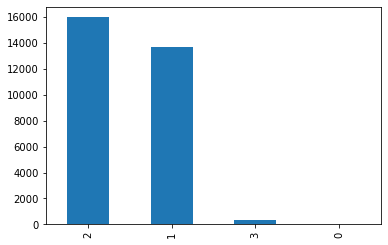

In [15]:
#Showcasing MARRIAGE variable (1 = married; 2 = single; 3 = others)
df1.MARRIAGE.value_counts().plot(kind = 'bar')

In [16]:
#data cleaning for Marriage
#MARRIAGE (1 = married; 2 = single; 3 = others)
df1.loc [:,'MARRIAGE'][df1['MARRIAGE'] == 0] = 3
df1.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

default_payment_result  MARRIAGE
0                       1           10453
                        2           12623
                        3             288
1                       1            3206
                        2            3341
                        3              89
dtype: int64
MARRIAGE                    1      2    3
default_payment_result                   
0                       10453  12623  288
1                        3206   3341   89


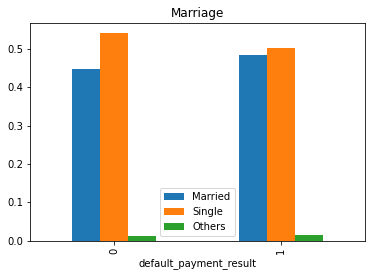

In [17]:
#grouping default payment next month by marriage
df1_marriage = df1.groupby(['default_payment_result', 'MARRIAGE']).size()
print(df1_marriage)

df1_marriage = df1_marriage.unstack()
print(df1_marriage)

df1_marriage.loc[1] = df1_marriage.loc[1] / 6636
df1_marriage.loc[0] = df1_marriage.loc[0] / 23364

df1_marriage.plot(kind = 'bar')
plt.title('Marriage')
plt.legend(['Married', 'Single', 'Others'])
plt.show()

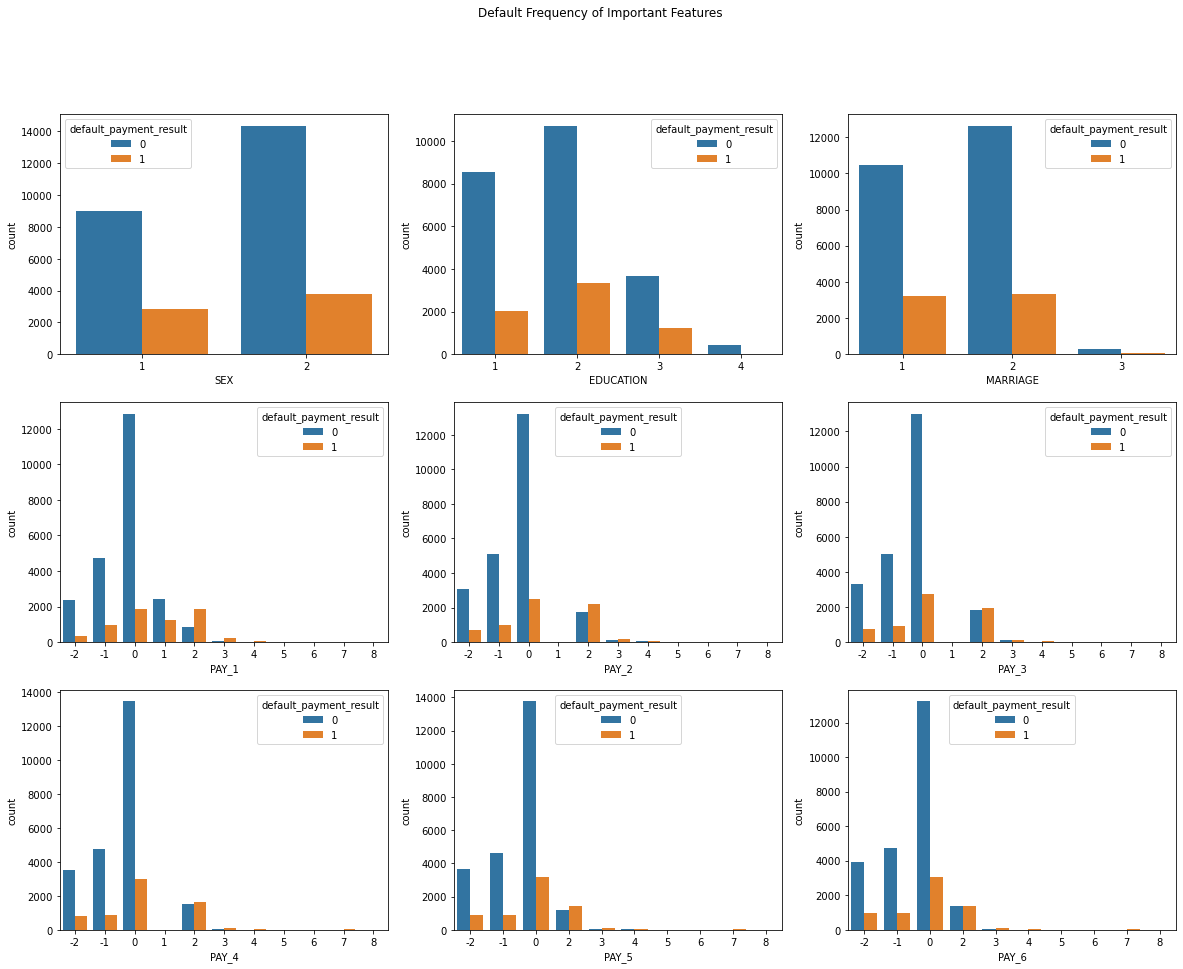

In [18]:
# Creating a new dataframe with categorical variables
subset = df1[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default_payment_result']]

f, axes = plt.subplots(3, 3, figsize = (20, 15), facecolor = 'white')
f.suptitle('Default Frequency of Important Features')
ax1 = sns.countplot(x = "SEX", hue = "default_payment_result", data = subset, ax = axes[0,0])
ax2 = sns.countplot(x = "EDUCATION", hue = "default_payment_result", data = subset, ax = axes[0,1])
ax3 = sns.countplot(x = "MARRIAGE", hue = "default_payment_result", data = subset, ax = axes[0,2])
ax4 = sns.countplot(x = "PAY_1", hue = "default_payment_result", data = subset, ax = axes[1,0])
ax5 = sns.countplot(x = "PAY_2", hue = "default_payment_result", data = subset, ax = axes[1,1])
ax6 = sns.countplot(x = "PAY_3", hue = "default_payment_result", data = subset, ax = axes[1,2])
ax7 = sns.countplot(x = "PAY_4", hue = "default_payment_result", data = subset, ax = axes[2,0])
ax8 = sns.countplot(x = "PAY_5", hue = "default_payment_result", data = subset, ax = axes[2,1])
ax9 = sns.countplot(x = "PAY_6", hue = "default_payment_result", data = subset, ax = axes[2,2]);

Text(0.5, 0, 'Age')

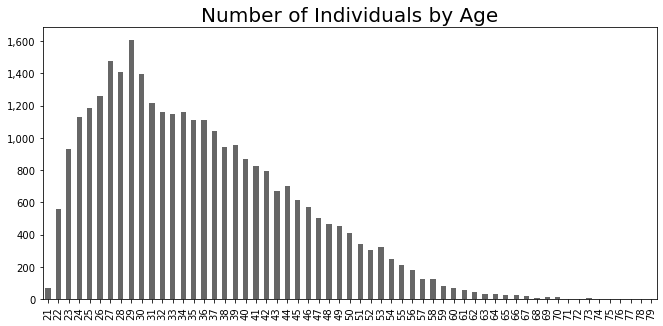

In [19]:
# Plot the number of individuals by age.
count_age = df1['AGE'].value_counts().sort_index(ascending = True)

# Fill in missing age counts with zeros.
for i in list(range(count_age.index.min(), count_age.index.max() + 1)):
    if i not in count_age.index:
        pd1 = pd.Series([0], index = [i])
        count_age = count_age.append(pd1)

count_age.sort_index(ascending = True, inplace = True)

# Plot the Series
fig, ax = plt.subplots(1, 1)
my_colors = ['0.4']
count_age.plot.bar(figsize = (11,5), 
                   rot = 90, 
                   fontsize = 10,
                   color = my_colors, 
                   ax = ax)

def yaxis_formatter_fn(x, pos):
    return "{:,}".format(int(x))

formatter = FuncFormatter(yaxis_formatter_fn)
ax.yaxis.set_major_formatter(formatter)

ax.xaxis.label.set_visible(False)

plt.title('Number of Individuals by Age', fontsize = 20)
plt.xlabel('Age', fontsize = 14)


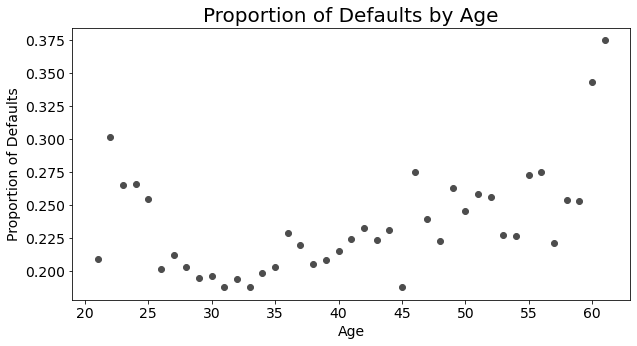

In [20]:
# for ages with at least 50 observations.
age_defaultpayment = df1.groupby(['AGE', 'default_payment_result']).size().unstack()

# Filter out ages with fewer than 50 observations.
age_defaultpayment = age_defaultpayment[age_defaultpayment.sum(axis = 1) > 50]

# Calculate proportions
age_defaultpayment = age_defaultpayment.div(age_defaultpayment.sum(axis = 1), axis = 'index')

# Plot
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
my_colors = ['0.3']
ax.scatter(x = age_defaultpayment.index,
           y = age_defaultpayment[1], 
           color = my_colors)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
plt.title('Proportion of Defaults by Age', fontsize = 20)
plt.ylabel('Proportion of Defaults', fontsize = 14)
plt.xlabel('Age', fontsize = 14)
plt.show()

In [21]:
# Separating features and target
y = df1.default_payment_result 
X = df1.drop('default_payment_result', axis = 1, inplace = False)

Split Data into Training and Testing Set

In [22]:
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

### Baseline Models

In [23]:
#Very very very basic baseline model
#Calculating the percentage of 1s (default) in the dataset
print(f'Percent of Default: {(y_test_baseline.mean() * 100)}%')

#Calculating the percentage of 0s (nondefault) in the dataset. 
print(f'Percent of Non-Default: {((1 - y_test_baseline.mean()) * 100)}%')

Percent of Default: 22.12222222222222%
Percent of Non-Default: 77.87777777777778%


Baseline Models of Decision Trees, Naive Bayes, KNN, Log Reg + Combined end result

In [24]:
def evaluate_model(model, X_test_baseline, y_test_baseline):
    from sklearn import metrics

    #Predicting Baseline Test data
    y_pred_baseline = model.predict(X_test_baseline)

    #accuracy, precision, recall, and f1-score
    accuracy = metrics.accuracy_score(y_test_baseline, y_pred_baseline)
    precision = metrics.precision_score(y_test_baseline, y_pred_baseline)
    recall = metrics.recall_score(y_test_baseline, y_pred_baseline)
    f1 = metrics.f1_score(y_test_baseline, y_pred_baseline)

    #(AUC)
    y_pred_proba_baseline = model.predict_proba(X_test_baseline)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test_baseline, y_pred_proba_baseline)
    auc = metrics.roc_auc_score(y_test_baseline, y_pred_proba_baseline)

    #Confussion matrix
    confusionmatrix = metrics.confusion_matrix(y_test_baseline, y_pred_baseline)

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'confusionmatrix': confusionmatrix}

In [25]:
#DummyClassifier. another very basic model that knows nothing about the dataset
dummy = DummyClassifier(strategy = 'stratified', random_state = 42)
dummy.fit(X_train_baseline, y_train_baseline)

#Evaluating the Model
dummy_eval = evaluate_model(dummy, X_test_baseline, y_test_baseline)

#Results
print('Accuracy:', dummy_eval['accuracy'])
print('Precision:', dummy_eval['precision'])
print('Recall:', dummy_eval['recall'])
print('F1 Score:', dummy_eval['f1'])
print('Area Under Curve:', dummy_eval['auc'])
print('Confusion Matrix:\n', dummy_eval['confusionmatrix'])


Accuracy: 0.6571111111111111
Precision: 0.21792890262751158
Recall: 0.21245605223505776
F1 Score: 0.21515768056968462
Area Under Curve: 0.49793868384330997
Confusion Matrix:
 [[5491 1518]
 [1568  423]]


In [26]:
#Decision Tree Baseline model 
dtree = tree.DecisionTreeClassifier(random_state = 42)
dtree.fit(X_train_baseline, y_train_baseline)

#Evaluating the Model
dtree_eval = evaluate_model(dtree, X_test_baseline, y_test_baseline)

#Results
print('Accuracy:', dtree_eval['accuracy'])
print('Precision:', dtree_eval['precision'])
print('Recall:', dtree_eval['recall'])
print('F1 Score:', dtree_eval['f1'])
print('Area Under Curve:', dtree_eval['auc'])
print('Confusion Matrix:\n', dtree_eval['confusionmatrix'])

Accuracy: 0.722
Precision: 0.3774580335731415
Recall: 0.3952787543947765
F1 Score: 0.38616290480863597
Area Under Curve: 0.6053205324946709
Confusion Matrix:
 [[5711 1298]
 [1204  787]]


In [27]:
#Naive Bayes Baseline model 
naivebayes = GaussianNB()
naivebayes.fit(X_train_baseline, y_train_baseline)

#Evaluating the Model
naivebayes_eval = evaluate_model(naivebayes, X_test_baseline, y_test_baseline)

# Results
print('Accuracy:', naivebayes_eval['accuracy'])
print('Precision:', naivebayes_eval['precision'])
print('Recall:', naivebayes_eval['recall'])
print('F1 Score:', naivebayes_eval['f1'])
print('Area Under Curve:', naivebayes_eval['auc'])
print('Confusion Matrix:\n', naivebayes_eval['confusionmatrix'])

Accuracy: 0.39911111111111114
Precision: 0.24878694309660343
Recall: 0.849824208940231
F1 Score: 0.3848953594176524
Area Under Curve: 0.659404078232199
Confusion Matrix:
 [[1900 5109]
 [ 299 1692]]


In [28]:
#KNN Baseline model 
knn = KNeighborsClassifier()
knn.fit(X_train_baseline, y_train_baseline)

#Evaluating the Model
knn_eval = evaluate_model(knn, X_test_baseline, y_test_baseline)

#Results
print('Accuracy:', knn_eval['accuracy'])
print('Precision:', knn_eval['precision'])
print('Recall:', knn_eval['recall'])
print('F1 Score:', knn_eval['f1'])
print('Area Under Curve:', knn_eval['auc'])
print('Confusion Matrix:\n', knn_eval['confusionmatrix'])

Accuracy: 0.7526666666666667
Precision: 0.3740621650589496
Recall: 0.17528879959819185
F1 Score: 0.2387140902872777
Area Under Curve: 0.6060362657783968
Confusion Matrix:
 [[6425  584]
 [1642  349]]


In [29]:
#Logistic Regression Baseline model 
log = LogisticRegression()
log.fit(X_train_baseline, y_train_baseline)

#Evaluating the Model
log_eval = evaluate_model(log, X_test_baseline, y_test_baseline)

#Results
print('Accuracy:', log_eval['accuracy'])
print('Precision:', log_eval['precision'])
print('Recall:', log_eval['recall'])
print('F1 Score:', log_eval['f1'])
print('Area Under Curve:', log_eval['auc'])
print('Confusion Matrix:\n', log_eval['confusionmatrix'])

Accuracy: 0.7783333333333333
Precision: 0.25
Recall: 0.0010045203415369162
F1 Score: 0.0020010005002501254
Area Under Curve: 0.644601197613544
Confusion Matrix:
 [[7003    6]
 [1989    2]]


### Baseline Models Plotting

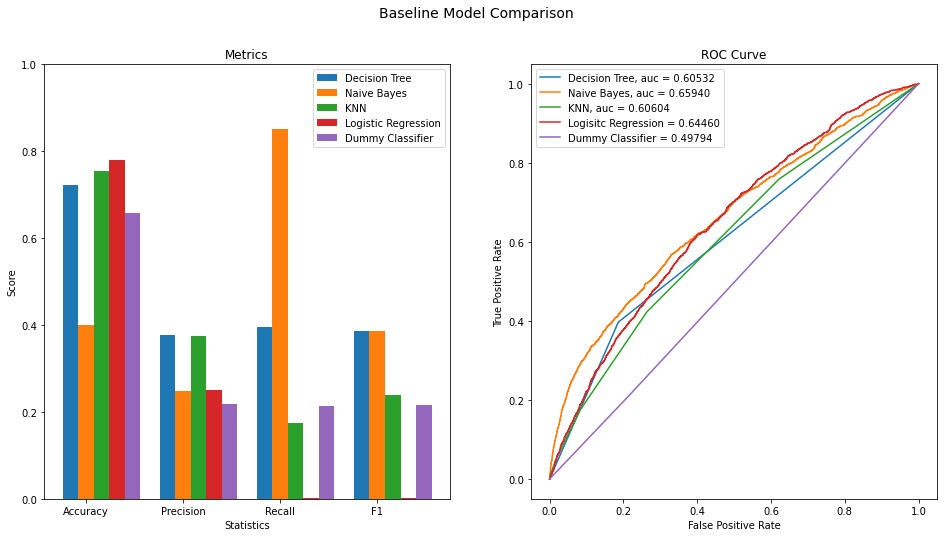

In [30]:
#plot setup
plot, (ax1, ax2) = plt.subplots(1, 2)
plot.suptitle('Baseline Model Comparison', fontsize=14)
plot.set_figheight(8)
plot.set_figwidth(16)

#First plot Statistics
dtree_score = [dtree_eval['accuracy'], dtree_eval['precision'], dtree_eval['recall'], dtree_eval['f1']]
naivebayes_score = [naivebayes_eval['accuracy'], naivebayes_eval['precision'], naivebayes_eval['recall'], naivebayes_eval['f1']]
knn_score = [knn_eval['accuracy'], knn_eval['precision'], knn_eval['recall'], knn_eval['f1']]
log_score = [log_eval['accuracy'], log_eval['precision'], log_eval['recall'], log_eval['f1']]
dummy_score = [dummy_eval['accuracy'], dummy_eval['precision'], dummy_eval['recall'], dummy_eval['f1']]

barWidth = 0.16
p1 = np.arange(len(dtree_score))
p2 = [x + barWidth for x in p1]
p3 = [x + barWidth for x in p2]
p4 = [x + barWidth for x in p3]
p5 = [x + barWidth for x in p4]

ax1.bar(p1, dtree_score, width = barWidth, label = 'Decision Tree')
ax1.bar(p2, naivebayes_score, width = barWidth, label = 'Naive Bayes')
ax1.bar(p3, knn_score, width = barWidth, label = 'KNN')
ax1.bar(p4, log_score, width = barWidth, label = 'Logistic Regression')
ax1.bar(p5, dummy_score, width = barWidth, label = 'Dummy Classifier')

#x and y axis
ax1.set_xlabel('Statistics')
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
ax1.set_xticks([r + (barWidth) for r in range(len(dtree_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score')
ax1.set_ylim(0, 1)

ax1.set_title('Metrics')
ax1.legend()

#Second plot ROC Curve
ax2.plot(dtree_eval['fpr'], dtree_eval['tpr'], label = 'Decision Tree, auc = {:0.5f}'.format(dtree_eval['auc']))
ax2.plot(naivebayes_eval['fpr'], naivebayes_eval['tpr'], label = 'Naive Bayes, auc = {:0.5f}'.format(naivebayes_eval['auc']))
ax2.plot(knn_eval['fpr'], knn_eval['tpr'], label = 'KNN, auc = {:0.5f}'.format(knn_eval['auc']))
ax2.plot(log_eval['fpr'], log_eval['tpr'], label = 'Logisitc Regression = {:0.5f}'.format(log_eval['auc']))
ax2.plot(dummy_eval['fpr'], dummy_eval['tpr'], label = 'Dummy Classifier = {:0.5f}'.format(dummy_eval['auc']))
#x and y axis
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')

ax2.set_title('ROC Curve')
ax2.legend()

plt.show()

### Feature Engineering (Data Normalization)

Conducting data normalization as many features are in different scales and units. 

Multicollinearity Analysis




<AxesSubplot:xlabel='0', ylabel='0'>

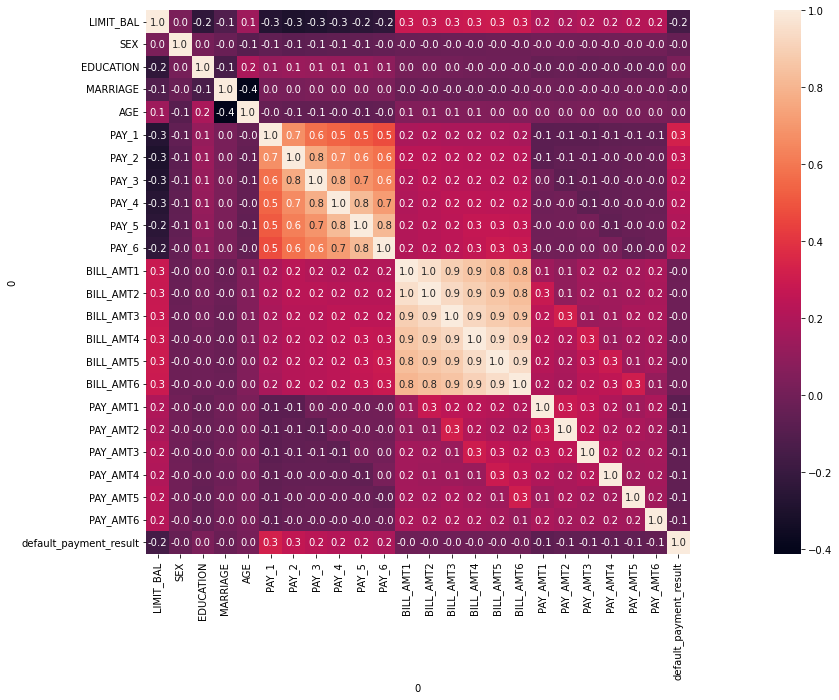

In [31]:
corr = df1.corr()
plt.subplots(figsize = (30,10))
sns.heatmap(corr, square = True, annot = True, fmt = ".1f" )  

<AxesSubplot:title={'center':'Correlation with Default'}, xlabel='0'>

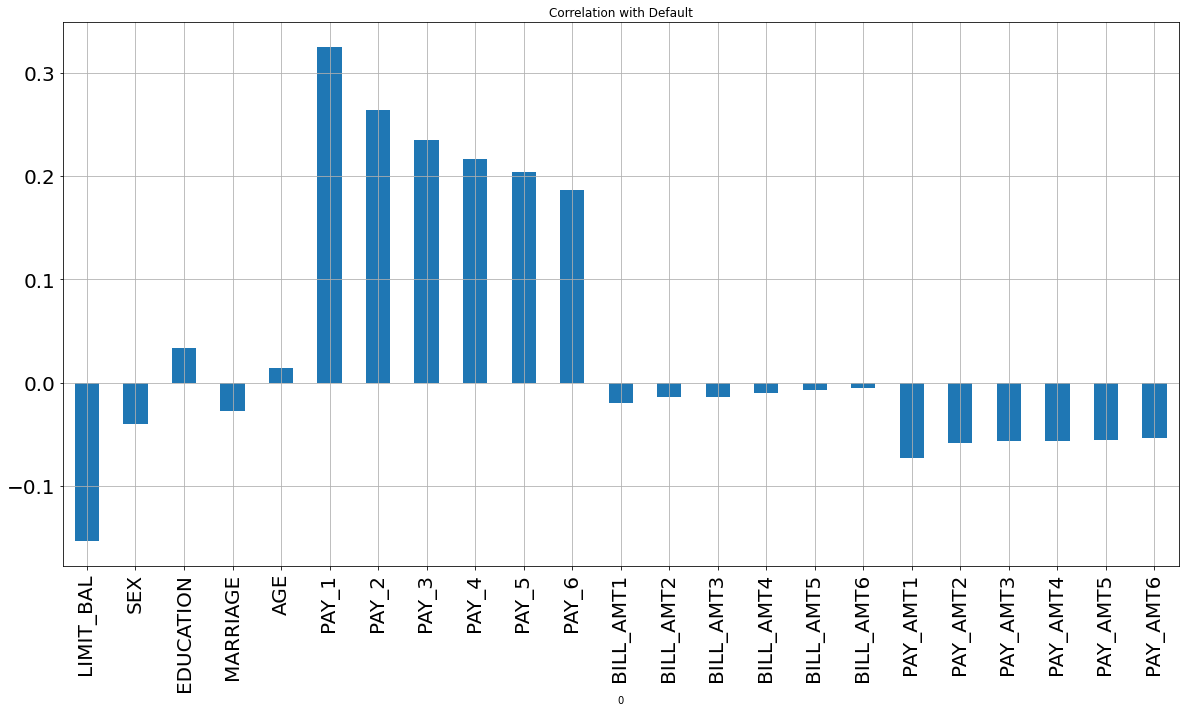

In [32]:
X.corrwith(df1['default_payment_result']).plot.bar(figsize = (20, 10), title = "Correlation with Default", fontsize = 20,rot = 90, grid = True)

In [33]:
upper = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.92)]
print(to_drop) 

['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']


In [34]:
df1

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_result
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,1.0,1.0,1.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3273.0,3456.0,3262.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14332.0,14949.0,15550.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28315.0,28960.0,29548.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20941.0,19147.0,19132.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000.0,1,3,1,39,0,0,0,0,0,...,88005.0,31238.0,15981.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29997,150000.0,1,3,2,43,-1,-1,-1,-1,0,...,8980.0,5191.0,1.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29998,30000.0,1,2,2,37,4,3,2,-1,0,...,20879.0,20583.0,19358.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29999,80000.0,1,3,1,41,1,-1,0,0,0,...,52775.0,11856.0,48945.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [35]:
df1 = df1.drop(df1[to_drop], axis = 1)
df1

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_result
1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3914.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,2,2683.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,0,29240.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,0,46991.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8618.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000.0,1,3,1,39,0,0,0,0,0,0,188949.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29997,150000.0,1,3,2,43,-1,-1,-1,-1,0,0,1684.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29998,30000.0,1,2,2,37,4,3,2,-1,0,0,3566.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29999,80000.0,1,3,1,41,1,-1,0,0,0,-1,-1644.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [36]:
#categorical data
for att in ['SEX', 'EDUCATION', 'MARRIAGE']:
  df1[att] = df1[att].astype('category')

#one-hot encoding
df1 = pd.concat([pd.get_dummies(df1['SEX'], prefix = 'SEX'), pd.get_dummies(df1['EDUCATION'], prefix = 'EDUCATION'), 
                pd.get_dummies(df1['MARRIAGE'], prefix = 'MARRIAGE'), df1], axis = 1)
# drop original columns
df1.drop(['EDUCATION'], axis = 1, inplace = True)
df1.drop(['SEX'], axis = 1, inplace = True)
df1.drop(['MARRIAGE'], axis = 1, inplace = True)

df1

,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,LIMIT_BAL,...,PAY_5,PAY_6,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_result
1,0,1,0,1,0,0,1,0,0,20000.0,...,-2,-2,3914.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,0,1,0,1,0,0,0,1,0,120000.0,...,0,2,2683.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,0,1,0,1,0,0,0,1,0,90000.0,...,0,0,29240.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,0,1,0,1,0,0,1,0,0,50000.0,...,0,0,46991.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,1,0,0,1,0,0,1,0,0,50000.0,...,0,0,8618.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,1,0,0,0,1,0,1,0,0,220000.0,...,0,0,188949.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29997,1,0,0,0,1,0,0,1,0,150000.0,...,0,0,1684.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29998,1,0,0,1,0,0,0,1,0,30000.0,...,0,0,3566.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29999,1,0,0,0,1,0,1,0,0,80000.0,...,0,-1,-1644.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [37]:
fil = (df1.PAY_1 == -1) | (df1.PAY_1 == -2)
df1.loc[fil, 'PAY_1'] = 0
df1.PAY_1.value_counts()
fil = (df1.PAY_2 == -1) | (df1.PAY_2 == -2)
df1.loc[fil, 'PAY_2'] = 0
df1.PAY_2.value_counts()
fil = (df1.PAY_3 == -1) | (df1.PAY_3 == -2)
df1.loc[fil, 'PAY_3'] = 0
df1.PAY_3.value_counts()
fil = (df1.PAY_4 == -1) | (df1.PAY_4 == -2)
df1.loc[fil, 'PAY_4'] = 0
df1.PAY_4.value_counts()
fil = (df1.PAY_5 == -1) | (df1.PAY_5 == -2)
df1.loc[fil, 'PAY_5'] = 0
df1.PAY_5.value_counts()
fil = (df1.PAY_6 == -1) | (df1.PAY_6 == -2)
df1.loc[fil, 'PAY_6'] = 0
df1.PAY_6.value_counts()

0    26921
2     2766
3      184
4       49
7       46
6       19
5       13
8        2
Name: PAY_6, dtype: int64

In [38]:
# Separating features and target
y = df1.default_payment_result 
X = df1.drop('default_payment_result', axis = 1, inplace = False)

Splitting Data into Training and Testing Set

In [39]:
# Dataset with standardized features
X_standardized = (X - X.mean()) / (X.std())             
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size = 0.3, stratify = y, random_state = 42)

### GridSearch Models

SVM

In [40]:
SVM = SVC(random_state = 42)
SVM.fit(X_train, y_train)

y_test_svm = SVM.predict(X_test)

SVM_score = cross_val_score(SVM, X_train, y_train, cv = 5)
print("SVM Cross Validation score: " + str(SVM_score))
print("SVM Cross Validation Mean score: " + str(SVM_score.mean()))

SVM Cross Validation score: [0.82357143 0.8252381  0.81809524 0.815      0.82357143]
SVM Cross Validation Mean score: 0.8210952380952381


In [41]:
SVM_model_accuracy = accuracy_score(y_test, y_test_svm)
print('SVM Cross validation accuracy:', SVM_model_accuracy)

SVM Cross validation accuracy: 0.8171111111111111


Grid Search SVM

In [42]:
SVM_parameters = [{'C':[0.001, 0.01, 1, 10],'kernel': ['rbf','liner']}]

SVM_grid_search = GridSearchCV(estimator = SVM, param_grid = SVM_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
SVM_grid_search = SVM_grid_search.fit(X_train, y_train)
SVM_best_parameters = SVM_grid_search.best_params_
print("SVM Best Parameters:  ", SVM_best_parameters)

SVM Best Parameters:   {'C': 1, 'kernel': 'rbf'}


In [43]:
tuned_SVM = SVM_grid_search.predict(X_test)

svm_tuned_acc = accuracy_score(y_test, tuned_SVM)
svm_tuned_prec = precision_score(y_test, tuned_SVM)
svm_tuned_rec = metrics.recall_score(y_test, tuned_SVM)
svm_tuned_f1 = f1_score(y_test, tuned_SVM)
svm_tuned_roc = roc_auc_score(y_test, tuned_SVM)
svm_tuned_result = pd.DataFrame([['Tuned SVM Model', svm_tuned_acc, svm_tuned_prec, svm_tuned_rec, svm_tuned_f1, svm_tuned_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])
svm_tuned_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,Tuned SVM Model,0.817111,0.66289,0.352587,0.460328,0.650826


Grid Search KNN

In [44]:
k_range = list(range(1, 15))
leaf_size = list(range(1,15))
weight_options = ['uniform', 'distance']
knn_parameters = {'n_neighbors': k_range, 'leaf_size': leaf_size, 'weights': weight_options}

KNN_grid_search = GridSearchCV(estimator = knn, param_grid = knn_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
KNN_grid_search = KNN_grid_search.fit(X_train, y_train)

KNN_best_accuracy = KNN_grid_search.best_score_
print('KNN Cross validation accuracy:', KNN_best_accuracy)

KNN Cross validation accuracy: 0.8095714285714285


In [45]:
knn_best_parameters = KNN_grid_search.best_params_
print('KNN Best Parameters:  ', knn_best_parameters)

KNN Best Parameters:   {'leaf_size': 1, 'n_neighbors': 14, 'weights': 'uniform'}


In [46]:
tuned_knn = KNN_grid_search.predict(X_test)

knn_tuned_acc = accuracy_score(y_test, tuned_knn)
knn_tuned_prec = precision_score(y_test, tuned_knn)
knn_tuned_rec = metrics.recall_score(y_test, tuned_knn)
knn_tuned_f1 = f1_score(y_test, tuned_knn)
knn_tuned_roc = roc_auc_score(y_test, tuned_knn)
knn_tuned_result = pd.DataFrame([['Tuned KNN Model', knn_tuned_acc, knn_tuned_prec, knn_tuned_rec, knn_tuned_f1, knn_tuned_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])

knn_tuned_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,Tuned KNN Model,0.811333,0.654699,0.311401,0.422056,0.632374


Grid Search Decision Tree


In [47]:
dtree_parameters = {'max_depth':[2,4,6,8,10], 'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}
dt_grid_search = GridSearchCV(estimator = dtree, param_grid = dtree_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
dt_grid_search = dt_grid_search.fit(X_train, y_train)

dt_best_accuracy = dt_grid_search.best_score_
print('Decision Tree Cross validation accuracy: ', dt_best_accuracy)

Decision Tree Cross validation accuracy:  0.8220476190476191


In [48]:
dt_best_parameters = dt_grid_search.best_params_
print('Decision Tree Best Parameters:  ', dt_best_parameters)

Decision Tree Best Parameters:   {'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 2}


In [49]:
tuned_dt = dt_grid_search.predict(X_test)

dt_tuned_acc = accuracy_score(y_test, tuned_dt)
dt_tuned_prec = precision_score(y_test, tuned_dt)
dt_tuned_rec = recall_score(y_test, tuned_dt)
dt_tuned_f1 = f1_score(y_test, tuned_dt)
dt_tuned_roc = roc_auc_score(y_test, tuned_dt)
dt_tuned_result = pd.DataFrame([['Tuned Decision Tree', dt_tuned_acc, dt_tuned_prec, dt_tuned_rec, dt_tuned_f1, dt_tuned_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])

dt_tuned_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,Tuned Decision Tree,0.817778,0.663866,0.357107,0.464402,0.652872


Grid Search Logistic Regression

In [50]:
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10], 'class_weight': [None, 'balanced'], 'penalty': ['l1', 'l2']}
lr_grid_search = GridSearchCV(estimator = log, param_grid = lr_params, scoring = 'accuracy', cv = 10, n_jobs = -1)
lr_grid_search = lr_grid_search.fit(X_train, y_train)

lr_best_accuracy = lr_grid_search.best_score_
print('Logistic Regression Cross validation accuracy:', lr_best_accuracy)

Logistic Regression Cross validation accuracy: 0.82


In [51]:
lr_best_parameters = lr_grid_search.best_params_
print('Logistic Regression Best Parameters:  ', lr_best_parameters)

Logistic Regression Best Parameters:   {'C': 0.1, 'class_weight': None, 'penalty': 'l2'}


In [52]:
tuned_lr = lr_grid_search.predict(X_test)

lr_tuned_acc = accuracy_score(y_test, tuned_lr)
lr_tuned_prec = precision_score(y_test, tuned_lr)
lr_tuned_rec = recall_score(y_test, tuned_lr)
lr_tuned_f1 = f1_score(y_test, tuned_lr)
lr_tuned_roc = roc_auc_score(y_test, tuned_lr)
lr_tuned_result = pd.DataFrame([['Tuned Logistic Regression', lr_tuned_acc, lr_tuned_prec, lr_tuned_rec, lr_tuned_f1, lr_tuned_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])

lr_tuned_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,Tuned Logistic Regression,0.814222,0.666319,0.320944,0.43322,0.637644


Stochastic Gradient Descent

In [53]:
sgd = SGDClassifier(loss = 'log_loss', penalty = 'l1', learning_rate = 'optimal', random_state = 1)
sgd.fit(X_train, y_train)

SGDClassifier(loss='log_loss', penalty='l1', random_state=1)

In [54]:
untuned_sgd = sgd.predict(X_test)

sgd_untuned_acc = accuracy_score(y_test, untuned_sgd)
sgd_untuned_prec = precision_score(y_test, untuned_sgd)
sgd_untuned_rec = recall_score(y_test, untuned_sgd)
sgd_untuned_f1 = f1_score(y_test, untuned_sgd)
sgd_untuned_roc = roc_auc_score(y_test, untuned_sgd)
sgd_untuned_result = pd.DataFrame([['Before Tuning: Stochastic Gradient Descent', sgd_untuned_acc, sgd_untuned_prec, sgd_untuned_rec, sgd_untuned_f1, sgd_untuned_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])
sgd_untuned_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,Before Tuning: Stochastic Gradient Descent,0.812222,0.640261,0.345053,0.448433,0.64499


In [55]:
sgd_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0], 'class_weight': [None, 'balanced']}
sgd_grid_search = GridSearchCV(estimator = sgd, param_grid = sgd_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
sgd_grid_search = sgd_grid_search.fit(X_train, y_train)

sgd_best_accuracy = sgd_grid_search.best_score_
print('Accuracy on Cross Validation set:', sgd_best_accuracy)

Accuracy on Cross Validation set: 0.8185238095238094


In [56]:
sgd_best_parameters = sgd_grid_search.best_params_
print('Stochastic Gradient Descent Best Parameters:  ', sgd_best_parameters)

Stochastic Gradient Descent Best Parameters:   {'alpha': 0.001, 'class_weight': None}


In [57]:
tuned_sgd = sgd_grid_search.predict(X_test)

sgd_prob = sgd_grid_search.predict_proba(X_test)

sgd_tuned_acc = accuracy_score(y_test, tuned_sgd)
sgd_tuned_prec = precision_score(y_test, tuned_sgd)
sgd_tuned_rec = recall_score(y_test, tuned_sgd)
sgd_tuned_f1 = f1_score(y_test, tuned_sgd)
sgd_tuned_roc = roc_auc_score(y_test, tuned_sgd)
sgd_tuned_result = pd.DataFrame([['Tuned Stochastic Gradient Descent ', sgd_tuned_acc, sgd_tuned_prec, sgd_tuned_rec, sgd_tuned_f1, sgd_tuned_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])

sgd_tuned_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,Tuned Stochastic Gradient Descent,0.817889,0.700456,0.30889,0.428721,0.635683


Naive Bayes Smoothing

In [58]:
# https://www.analyticsvidhya.com/blog/2021/01/gaussian-naive-bayes-with-hyperpameter-tuning/
nb_parameters = {'var_smoothing': np.logspace(0, -9, num = 100)}
nb_grid_search = GridSearchCV(estimator = naivebayes, param_grid = nb_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
nb_grid_search = nb_grid_search.fit(X_train, y_train)

nb_best_accuracy = nb_grid_search.best_score_
print('Accuracy on Cross Validation set :', nb_best_accuracy)

Accuracy on Cross Validation set : 0.8036190476190477


In [59]:
nb_best_parameters = nb_grid_search.best_params_
print('Naive Bayes Best Parameters:  ', nb_best_parameters)

Naive Bayes Best Parameters:   {'var_smoothing': 1.0}


In [60]:
tuned_nb = nb_grid_search.predict(X_test)

nb_prob = nb_grid_search.predict_proba(X_test)

nb_tuned_acc = accuracy_score(y_test, tuned_nb)
nb_tuned_prec = precision_score(y_test, tuned_nb)
nb_tuned_rec = recall_score(y_test, tuned_nb)
nb_tuned_f1 = f1_score(y_test, tuned_nb)
nb_tuned_roc = roc_auc_score(y_test, tuned_nb)
nb_tuned_result = pd.DataFrame([['Tuned Naive Bayes ', nb_tuned_acc, nb_tuned_prec, nb_tuned_rec, nb_tuned_f1, nb_tuned_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])

nb_tuned_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,Tuned Naive Bayes,0.799556,0.569311,0.385736,0.45988,0.651421


In [61]:
gridsearch = pd.concat([svm_tuned_result, knn_tuned_result, dt_tuned_result, lr_tuned_result, nb_tuned_result, sgd_tuned_result], axis=0)
gridsearch = gridsearch.style.set_caption('Model Results after Hyperparameter Tuning')
gridsearch

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,Tuned SVM Model,0.817111,0.662890,0.352587,0.460328,0.650826
0,Tuned KNN Model,0.811333,0.654699,0.311401,0.422056,0.632374
0,Tuned Decision Tree,0.817778,0.663866,0.357107,0.464402,0.652872
0,Tuned Logistic Regression,0.814222,0.666319,0.320944,0.433220,0.637644
0,Tuned Naive Bayes,0.799556,0.569311,0.385736,0.459880,0.651421
0,Tuned Stochastic Gradient Descent,0.817889,0.700456,0.308890,0.428721,0.635683


ROC Curve

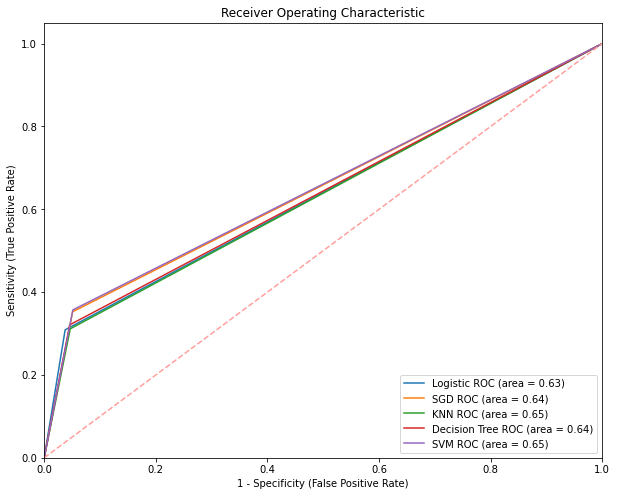

In [62]:
#false positive rate, fpr= FP/(TN+FP) OR fpr = 1-specificty, tpr = sensitivity 
y_pred_log_p = lr_grid_search.predict_proba(X_test)[:,1]
y_pred_sgd_p = sgd_grid_search.predict_proba(X_test)[:,1]
y_pred_knn_p = KNN_grid_search.predict_proba(X_test)[:,1]
y_pred_dt_p = dt_grid_search.predict_proba(X_test)[:,1]
#y_pred_svc_p = SVM_grid_search.predict(X_test)[:,1]
y_pred_nb_p = nb_grid_search.predict_proba(X_test)[:,1]

model = [KNN_grid_search, lr_grid_search, dt_grid_search, sgd_grid_search, nb_grid_search]

models=[tuned_sgd, tuned_SVM, tuned_knn, tuned_lr, tuned_dt, tuned_nb]
label=['Logistic', 'SGD', 'KNN', 'Decision Tree', 'SVM', 'NB']

#plotting ROC curves
plt.figure(figsize = (10, 8))
m = np.arange(5)
for m in m:
    fpr, tpr,thresholds = metrics.roc_curve(y_test, models[m])
    auc = metrics.roc_auc_score(y_test, model[m].predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (label[m], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

PR Curve

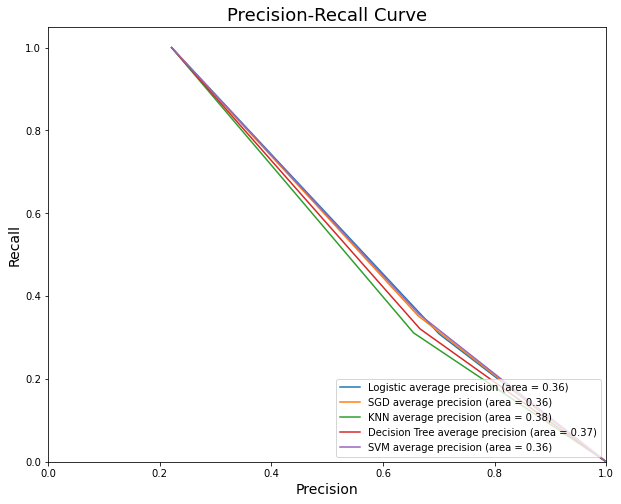

In [63]:
# false positive rate, fpr = FP/(TN+FP) OR fpr = 1-specificty, tpr = sensitivity 
y_pred_log_p = lr_grid_search.predict_proba(X_test)[:,1]
y_pred_sgd_p = sgd_grid_search.predict_proba(X_test)[:,1]
y_pred_knn_p = KNN_grid_search.predict_proba(X_test)[:,1]
y_pred_dt_p = dt_grid_search.predict_proba(X_test)[:,1]
#y_pred_svc_p = SVM_grid_search.predict(X_test)[:,1]
y_pred_nb_p = nb_grid_search.predict_proba(X_test)[:,1]

model = [KNN_grid_search, lr_grid_search, dt_grid_search, sgd_grid_search, nb_grid_search]

models=[tuned_sgd, tuned_SVM, tuned_knn, tuned_lr, tuned_dt, tuned_nb]
label=['Logistic', 'SGD', 'KNN', 'Decision Tree', 'SVM', 'NB']

# plotting PR curves
plt.figure(figsize = (10, 8))
m = np.arange(5)
for m in m:
    precision, recall, thresholds_pr = metrics. precision_recall_curve(y_test, models[m])
    avg_pre = metrics.average_precision_score(y_test, model[m].predict(X_test))
    plt.plot(precision, recall, label = '%s average precision (area = %0.2f)' % (label[m], avg_pre))


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision', fontsize = 14)
plt.ylabel('Recall', fontsize = 14)
plt.title('Precision-Recall Curve', fontsize = 18)
plt.legend(loc = "lower right")
plt.show()

#### **Undersampling / Oversampling Method**

Random Undersampling

In [64]:
def over_under_sample(X_train, y_train, Under = True, Over = True):
    """
    Input: training features and target
    Output: under/oversampled datasets
    """
    rus = RandomUnderSampler(random_state = 42)
    ros = RandomOverSampler(random_state = 42)

    if Under and Over:
        X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
        X_train_over, y_train_over = ros.fit_resample(X_train, y_train)
        return X_train_under, y_train_under, X_train_over, y_train_over
    elif Under:
        X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
        return X_train_under, y_train_under
    else:
        X_train_over, y_train_over = ros.fit_resample(X_train, y_train)
        return X_train_over, y_train_over


X_train_under, y_train_under, X_train_over, y_train_over = over_under_sample(X_train, y_train, Under = True, Over = True)

print("Before random undersampling :" , Counter(y_train))
print("After random undersampling :" , Counter(y_train_under))

Before random undersampling : Counter({0: 16355, 1: 4645})
After random undersampling : Counter({0: 4645, 1: 4645})


Logistic Regression - Undersampling

In [65]:
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10], 'class_weight': [None, 'balanced'], 'penalty': ['l1', 'l2']}
lr_under_grid_search = GridSearchCV(estimator = log, param_grid = lr_params, scoring = 'accuracy', cv = 10, n_jobs = -1)
lr_under_grid_search = lr_under_grid_search.fit(X_train_under, y_train_under)

lr_under_best_accuracy = lr_under_grid_search.best_score_
print('Logistic Regression Cross validation accuracy :', lr_under_best_accuracy)

Logistic Regression Cross validation accuracy : 0.7058127018299246


In [66]:
lr_under_best_parameters = lr_under_grid_search.best_params_
print('Logistic Regression - Undersampling Best Parameters:  ', lr_under_best_parameters)

Logistic Regression - Undersampling Best Parameters:   {'C': 0.01, 'class_weight': None, 'penalty': 'l2'}


In [67]:
tuned_lr_under = lr_under_grid_search.predict(X_test)

lr_under_roc = roc_auc_score(y_test, tuned_lr_under)
lr_under_acc = accuracy_score(y_test, tuned_lr_under)
lr_under_prec = precision_score(y_test, tuned_lr_under)
lr_under_rec = recall_score(y_test, tuned_lr_under)
lr_under_f1 = f1_score(y_test, tuned_lr_under)
lr_under_result = pd.DataFrame([['Logistic Regression - Undersampled', lr_under_acc, lr_under_prec, lr_under_rec, lr_under_f1, lr_under_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])

lr_under_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,Logistic Regression - Undersampled,0.776,0.494346,0.54897,0.520228,0.694731


Logistic Regression - Oversampling 

In [68]:
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10], 'class_weight': [None, 'balanced'], 'penalty': ['l1', 'l2']}
lr_over_grid_search = GridSearchCV(estimator = log, param_grid = lr_params, scoring = 'accuracy', cv = 10, n_jobs = -1)
lr_over_grid_search = lr_grid_search.fit(X_train_over, y_train_over)

lr_over_best_accuracy = lr_over_grid_search.best_score_
print('Logistic Regression Cross validation accuracy :', lr_over_best_accuracy)

Logistic Regression Cross validation accuracy : 0.7061754815041271


In [69]:
lr_over_best_parameters = lr_over_grid_search.best_params_
print('Logistic Regression - Oversampling Best Parameters:  ', lr_over_best_parameters)

Logistic Regression - Oversampling Best Parameters:   {'C': 0.01, 'class_weight': None, 'penalty': 'l2'}


In [70]:
tuned_lr_over = lr_over_grid_search.predict(X_test)

lr_over_roc = roc_auc_score(y_test, tuned_lr_over)
lr_over_acc = accuracy_score(y_test, tuned_lr_over)
lr_over_prec = precision_score(y_test, tuned_lr_over)
lr_over_rec = recall_score(y_test, tuned_lr_over)
lr_over_f1 = f1_score(y_test, tuned_lr_over)
lr_over_result = pd.DataFrame([['Logistic Regression - Oversampled', lr_over_acc, lr_over_prec, lr_over_rec, lr_over_f1, lr_over_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])

lr_over_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,Logistic Regression - Oversampled,0.776333,0.495009,0.547966,0.520143,0.694585


SVM - Undersampling

In [71]:
SVM_parameters = [{'C':[0.001, 0.01, 1, 10],'kernel': ['rbf']}]

SVM_under_grid_search = GridSearchCV(estimator = SVM, param_grid = SVM_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
SVM_under_grid_search = SVM_under_grid_search.fit(X_train_under, y_train_under)
SVM_under_best_parameters = SVM_under_grid_search.best_params_
print('SVM Undersampling Best Parameters:  ', SVM_under_best_parameters)

SVM Undersampling Best Parameters:   {'C': 1, 'kernel': 'rbf'}


In [72]:
tuned_SVM_under = SVM_under_grid_search.predict(X_test)

svm_under_acc = accuracy_score(y_test, tuned_SVM_under)
svm_under_prec = precision_score(y_test, tuned_SVM_under)
svm_under_rec = metrics.recall_score(y_test, tuned_SVM_under)
svm_under_f1 = f1_score(y_test, tuned_SVM_under)
svm_under_roc = roc_auc_score(y_test, tuned_SVM_under)
svm_under_result = pd.DataFrame([['SVM - Undersampled', svm_under_acc, svm_under_prec, svm_under_rec, svm_under_f1, svm_under_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])
svm_under_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,SVM - Undersampled,0.750444,0.451502,0.596183,0.513853,0.695224


SVM - Oversampling

In [73]:
SVM_parameters = [{'C':[0.001,0.01,1,10],'kernel': ['rbf']}]

SVM_over_grid_search = GridSearchCV(estimator = SVM, param_grid = SVM_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
SVM_over_grid_search = SVM_grid_search.fit(X_train_over, y_train_over)
SVM_over_best_parameters = SVM_over_grid_search.best_params_
print('SVM Oversampling Best Parameters:  ', SVM_over_best_parameters)

SVM Oversampling Best Parameters:   {'C': 10, 'kernel': 'rbf'}


In [74]:
tuned_SVM_over = SVM_over_grid_search.predict(X_test)

svm_over_acc = accuracy_score(y_test, tuned_SVM_over)
svm_over_prec = precision_score(y_test, tuned_SVM_over)
svm_over_rec = metrics.recall_score(y_test, tuned_SVM_over)
svm_over_f1 = f1_score(y_test, tuned_SVM_over)
svm_over_roc = roc_auc_score(y_test, tuned_SVM_over)
svm_over_result = pd.DataFrame([['SVM - Oversampled', svm_over_acc, svm_over_prec, svm_over_rec, svm_over_f1, svm_over_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])

svm_over_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,SVM - Oversampled,0.755222,0.45598,0.551482,0.499204,0.68229


KNN - Undersampling


In [75]:
k_range = list(range(1, 15))
leaf_size = list(range(1, 15))
weight_options = ['uniform', 'distance']
knn_parameters = {'n_neighbors': k_range, 'leaf_size': leaf_size, 'weights': weight_options}

KNN_under_grid_search = GridSearchCV(estimator = knn, param_grid = knn_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
KNN_under_grid_search = KNN_under_grid_search.fit(X_train_under, y_train_under)

KNN_under_best_accuracy = KNN_under_grid_search.best_score_
print('KNN Cross validation accuracy:', KNN_under_best_accuracy)

KNN Cross validation accuracy: 0.6916038751345532


In [76]:
knn_under_best_parameters = KNN_under_grid_search.best_params_
print('KNN - Undersampling Best Parameters:  ', knn_under_best_parameters)

KNN - Undersampling Best Parameters:   {'leaf_size': 1, 'n_neighbors': 14, 'weights': 'uniform'}


In [77]:
tuned_knn_under = KNN_under_grid_search.predict(X_test)

knn_under_acc = accuracy_score(y_test, tuned_knn_under)
knn_under_prec = precision_score(y_test, tuned_knn_under)
knn_under_rec = metrics.recall_score(y_test, tuned_knn_under)
knn_under_f1 = f1_score(y_test, tuned_knn_under)
knn_under_roc = roc_auc_score(y_test, tuned_knn_under)
knn_under_result = pd.DataFrame([['KNN - Undersampled', knn_under_acc, knn_under_prec, knn_under_rec, knn_under_f1, knn_under_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])

knn_under_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,KNN - Undersampled,0.747111,0.444183,0.569563,0.49912,0.683555


KNN - Oversampling

In [78]:
k_range = list(range(1, 15))
leaf_size = list(range(1,15))
weight_options = ['uniform', 'distance']
knn_parameters = {'n_neighbors': k_range, 'leaf_size': leaf_size, 'weights': weight_options}

KNN_over_grid_search = GridSearchCV(estimator = knn,param_grid = knn_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
KNN_over_grid_search = KNN_over_grid_search.fit(X_train_over, y_train_over)

KNN_over_best_accuracy = KNN_over_grid_search.best_score_
print('KNN Cross validation accuracy:', KNN_over_best_accuracy)

KNN Cross validation accuracy: 0.8878018954448181


In [79]:
knn_over_best_parameters = KNN_over_grid_search.best_params_
print('KNN - Oversampling Best Parameters:  ', knn_over_best_parameters)

KNN - Oversampling Best Parameters:   {'leaf_size': 1, 'n_neighbors': 1, 'weights': 'uniform'}


In [80]:
tuned_knn_over = KNN_over_grid_search.predict(X_test)

knn_over_acc = accuracy_score(y_test, tuned_knn_over)
knn_over_prec = precision_score(y_test, tuned_knn_over)
knn_over_rec = metrics.recall_score(y_test, tuned_knn_over)
knn_over_f1 = f1_score(y_test, tuned_knn_over)
knn_over_roc = roc_auc_score(y_test, tuned_knn_over)
knn_over_result = pd.DataFrame([['KNN - Oversampled', knn_over_acc, knn_over_prec, knn_over_rec, knn_over_f1, knn_over_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])

knn_over_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,KNN - Oversampled,0.732778,0.394817,0.390256,0.392523,0.610166


Decision Tree - Undersampled

In [81]:
dtree_parameters = {'max_depth': [2,4,6,8,10],'min_samples_leaf': [2,4,6,8,10], 'min_samples_split': [2,4,6,8,10]}
dt_under_grid_search = GridSearchCV(estimator = dtree, param_grid = dtree_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
dt_under_grid_search = dt_under_grid_search.fit(X_train_under, y_train_under)

dt_under_best_accuracy = dt_under_grid_search.best_score_
print('Decision Tree Cross validation accuracy: ', dt_under_best_accuracy)

Decision Tree Cross validation accuracy:  0.6906350914962325


In [82]:
dt_under_best_parameters = dt_under_grid_search.best_params_
print('Decision Tree - Undersampled Best Parameters:  ', dt_under_best_parameters)

Decision Tree - Undersampled Best Parameters:   {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [83]:
tuned_dt_under = dt_under_grid_search.predict(X_test)

dt_under_roc = roc_auc_score(y_test, tuned_dt_under)
dt_under_acc = accuracy_score(y_test, tuned_dt_under)
dt_under_prec = precision_score(y_test, tuned_dt_under)
dt_under_rec = recall_score(y_test, tuned_dt_under)
dt_under_f1 = f1_score(y_test, tuned_dt_under)
dt_under_result = pd.DataFrame([['Decision Tree - Undersampled', dt_under_acc, dt_under_prec, dt_under_rec, dt_under_f1, dt_under_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])

dt_under_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,Decision Tree - Undersampled,0.769889,0.482332,0.548468,0.513278,0.690627


Decision Tree - Oversampled

In [84]:
dtree_parameters = {'max_depth':[2,4,6,8,10],'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}
dt_over_grid_search = GridSearchCV(estimator = dtree, param_grid = dtree_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
dt_over_grid_search = dt_over_grid_search.fit(X_train_over, y_train_over)

dt_over_best_accuracy = dt_over_grid_search.best_score_
print('Decision Tree Cross validation accuracy: ', dt_over_best_accuracy)

Decision Tree Cross validation accuracy:  0.7408132069703455


In [85]:
dt_over_best_parameters = dt_over_grid_search.best_params_
print('Decision Tree - Undersampled Best Parameters:  ', dt_over_best_parameters)

Decision Tree - Undersampled Best Parameters:   {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [86]:
tuned_dt_over = dt_over_grid_search.predict(X_test)

dt_over_roc = roc_auc_score(y_test, tuned_dt_over)
dt_over_acc = accuracy_score(y_test, tuned_dt_over)
dt_over_prec = precision_score(y_test, tuned_dt_over)
dt_over_rec = recall_score(y_test, tuned_dt_over)
dt_over_f1 = f1_score(y_test, tuned_dt_over)
dt_over_result = pd.DataFrame([['Decision Tree - Oversampled', dt_over_acc, dt_over_prec, dt_over_rec, dt_over_f1, dt_over_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])
#dt_over_result = model_results.append(dt_over_result, ignore_index = True)
dt_over_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,Decision Tree - Oversampled,0.741778,0.435739,0.567052,0.492798,0.679231


Stochastic Gradient Descent - Undersampling 

In [87]:
sgd_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0], 'class_weight': [None, 'balanced']}
sgd_under_grid_search = GridSearchCV(estimator = sgd, param_grid = sgd_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
sgd_under_grid_search = sgd_under_grid_search.fit(X_train_under, y_train_under)

sgd_under_best_accuracy = sgd_under_grid_search.best_score_
print('Accuracy on Cross Validation set :', sgd_under_best_accuracy)

Accuracy on Cross Validation set : 0.7006458557588805


In [88]:
sgd_under_best_parameters = sgd_under_grid_search.best_params_
print('Stochastic Gradient Descent - Undersampled Best Parameters:  ', sgd_under_best_parameters)

Stochastic Gradient Descent - Undersampled Best Parameters:   {'alpha': 0.01, 'class_weight': None}


In [89]:
tuned_sgd_under = sgd_under_grid_search.predict(X_test)

sgd_prob = sgd_grid_search.predict_proba(X_test)

sgd_under_roc=roc_auc_score(y_test, tuned_sgd_under)
sgd_under_acc = accuracy_score(y_test, tuned_sgd_under)
sgd_under_prec = precision_score(y_test, tuned_sgd_under)
sgd_under_rec = recall_score(y_test, tuned_sgd_under)
sgd_under_f1 = f1_score(y_test, tuned_sgd_under)
sgd_under_result = pd.DataFrame([['SGD - Undersampled', sgd_under_acc, sgd_under_prec, sgd_under_rec, sgd_under_f1, sgd_under_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])
#model_results = model_results.append(model, ignore_index = True)
sgd_under_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,SGD - Undersampled,0.779111,0.500703,0.536916,0.518177,0.692413


Stochastic Gradient Descent - Oversampling


In [90]:
sgd_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0], 'class_weight': [None, 'balanced']}
sgd_over_grid_search = GridSearchCV(estimator = sgd, param_grid = sgd_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
sgd_over_grid_search = sgd_over_grid_search.fit(X_train_over, y_train_over)

sgd_over_best_accuracy = sgd_over_grid_search.best_score_
print('Accuracy on Cross Validation set :', sgd_over_best_accuracy)

Accuracy on Cross Validation set : 0.7036686028737389


In [91]:
sgd_over_best_parameters = sgd_over_grid_search.best_params_
print('Stochastic Gradient Descent - Oversampled Best Parameters:  ', sgd_over_best_parameters)

Stochastic Gradient Descent - Oversampled Best Parameters:   {'alpha': 0.001, 'class_weight': None}


In [92]:
tuned_sgd_over = sgd_over_grid_search.predict(X_test)

sgd_prob = sgd_grid_search.predict_proba(X_test)

sgd_over_roc = roc_auc_score(y_test, tuned_sgd_over)
sgd_over_acc = accuracy_score(y_test, tuned_sgd_over)
sgd_over_prec = precision_score(y_test, tuned_sgd_over)
sgd_over_rec = recall_score(y_test, tuned_sgd_over)
sgd_over_f1 = f1_score(y_test, tuned_sgd_over)
sgd_over_result = pd.DataFrame([['SGD - Oversampled', sgd_over_acc, sgd_over_prec, sgd_over_rec, sgd_over_f1, sgd_over_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])
#model_results = model_results.append(model, ignore_index = True)
sgd_over_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,SGD - Oversampled,0.765111,0.474105,0.565545,0.515804,0.693673


Naive Bayes - Undersampling 

In [93]:
# https://www.analyticsvidhya.com/blog/2021/01/gaussian-naive-bayes-with-hyperpameter-tuning/
nb_parameters = {'var_smoothing': np.logspace(0, -9, num = 100)}
nb_under_grid_search = GridSearchCV(estimator = naivebayes, param_grid = nb_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
nb_under_grid_search = nb_under_grid_search.fit(X_train_under, y_train_under)

nb_under_best_accuracy = nb_under_grid_search.best_score_
print('Accuracy on Cross Validation set:', nb_under_best_accuracy)

Accuracy on Cross Validation set: 0.7001076426264801


In [94]:
nb_under_best_parameters = nb_under_grid_search.best_params_
print('Naive Bayes - Undersampled Best Parameters:  ', nb_under_best_parameters)

Naive Bayes - Undersampled Best Parameters:   {'var_smoothing': 0.003511191734215131}


In [95]:
tuned_nb_under = nb_under_grid_search.predict(X_test)

nb_prob_under = nb_under_grid_search.predict_proba(X_test)

nb_under_acc = accuracy_score(y_test, tuned_nb_under)
nb_under_prec = precision_score(y_test, tuned_nb_under)
nb_under_rec = recall_score(y_test, tuned_nb_under)
nb_under_f1 = f1_score(y_test, tuned_nb_under)
nb_under_roc = roc_auc_score(y_test, tuned_nb_under)
nb_under_result = pd.DataFrame([['Naive Bayes - Undersampled', nb_under_acc, nb_under_prec, nb_under_rec, nb_under_f1, nb_under_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])

nb_under_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,Naive Bayes - Undersampled,0.746222,0.442661,0.568056,0.49758,0.682444


Naive Bayes - Oversampling

In [96]:
# https://www.analyticsvidhya.com/blog/2021/01/gaussian-naive-bayes-with-hyperpameter-tuning/
nb_parameters = {'var_smoothing': np.logspace(0, -9, num = 100)}
nb_over_grid_search = GridSearchCV(estimator = naivebayes, param_grid = nb_parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
nb_over_grid_search = nb_over_grid_search.fit(X_train_under, y_train_under)

nb_over_best_accuracy = nb_over_grid_search.best_score_
print('Accuracy on Cross Validation set:', nb_over_best_accuracy)

Accuracy on Cross Validation set: 0.7001076426264801


In [97]:
nb_over_best_parameters = nb_over_grid_search.best_params_
print('Naive Bayes - Oversampled Best Parameters:  ', nb_over_best_parameters)

Naive Bayes - Oversampled Best Parameters:   {'var_smoothing': 0.003511191734215131}


In [98]:
tuned_nb_over = nb_over_grid_search.predict(X_test)

nb_prob_over = nb_over_grid_search.predict_proba(X_test)

nb_over_acc = accuracy_score(y_test, tuned_nb_over)
nb_over_prec = precision_score(y_test, tuned_nb_over)
nb_over_rec = recall_score(y_test, tuned_nb_over)
nb_over_f1 = f1_score(y_test, tuned_nb_over)
nb_over_roc = roc_auc_score(y_test, tuned_nb_over)
nb_over_result = pd.DataFrame([['Naive Bayes - Oversampled', nb_over_acc, nb_over_prec, nb_over_rec, nb_over_f1, nb_over_roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC'])

nb_over_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,Naive Bayes - Oversampled,0.746222,0.442661,0.568056,0.49758,0.682444


### Results of Oversampling / Undersampling Method

In [99]:
oversampled = pd.concat([svm_over_result, knn_over_result, dt_over_result, lr_over_result, nb_over_result, sgd_over_result], axis=0)
oversampled = oversampled.style.set_caption('Model Results after Random Oversampling Method')
oversampled

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,SVM - Oversampled,0.755222,0.455980,0.551482,0.499204,0.682290
0,KNN - Oversampled,0.732778,0.394817,0.390256,0.392523,0.610166
0,Decision Tree - Oversampled,0.741778,0.435739,0.567052,0.492798,0.679231
0,Logistic Regression - Oversampled,0.776333,0.495009,0.547966,0.520143,0.694585
0,Naive Bayes - Oversampled,0.746222,0.442661,0.568056,0.497580,0.682444
0,SGD - Oversampled,0.765111,0.474105,0.565545,0.515804,0.693673


In [100]:
undersampled = pd.concat([svm_under_result, knn_under_result, dt_under_result, lr_under_result, nb_under_result, sgd_under_result], axis=0)
undersampled = undersampled.style.set_caption('Model Results after Random Undersampling Method')
undersampled

,Model,Accuracy,Precision,Recall,F1-Score,ROC
0,SVM - Undersampled,0.750444,0.451502,0.596183,0.513853,0.695224
0,KNN - Undersampled,0.747111,0.444183,0.569563,0.499120,0.683555
0,Decision Tree - Undersampled,0.769889,0.482332,0.548468,0.513278,0.690627
0,Logistic Regression - Undersampled,0.776000,0.494346,0.548970,0.520228,0.694731
0,Naive Bayes - Undersampled,0.746222,0.442661,0.568056,0.497580,0.682444
0,SGD - Undersampled,0.779111,0.500703,0.536916,0.518177,0.692413
